<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#AB-Testing-Experiments-as-Statistical-inference" data-toc-modified-id="AB-Testing-Experiments-as-Statistical-inference-0.1">AB Testing Experiments as Statistical inference</a></span></li><li><span><a href="#What-exactly-do-we-mean-by-&quot;difference-between-groups&quot;?" data-toc-modified-id="What-exactly-do-we-mean-by-&quot;difference-between-groups&quot;?-0.2">What exactly do we mean by "difference between groups"?</a></span></li><li><span><a href="#Hypothesis-Tests" data-toc-modified-id="Hypothesis-Tests-0.3">Hypothesis Tests</a></span><ul class="toc-item"><li><span><a href="#Quantifying-comparison-valence" data-toc-modified-id="Quantifying-comparison-valence-0.3.1">Quantifying comparison <em>valence</em></a></span></li><li><span><a href="#Quantifying-comparison-magnitude:-effect-size" data-toc-modified-id="Quantifying-comparison-magnitude:-effect-size-0.3.2">Quantifying comparison magnitude: effect size</a></span></li><li><span><a href="#Quantifying-the-reliability-of-differences" data-toc-modified-id="Quantifying-the-reliability-of-differences-0.3.3">Quantifying the reliability of differences</a></span></li><li><span><a href="#Quantifying-magnitude-and-effect-size" data-toc-modified-id="Quantifying-magnitude-and-effect-size-0.3.4">Quantifying magnitude and effect size</a></span></li></ul></li></ul></li><li><span><a href="#Inferential-Statistics" data-toc-modified-id="Inferential-Statistics-1">Inferential Statistics</a></span><ul class="toc-item"><li><span><a href="#Type-I-Error,-Type-II-Error,-and-Inferential-Power" data-toc-modified-id="Type-I-Error,-Type-II-Error,-and-Inferential-Power-1.1">Type I Error, Type II Error, and Inferential Power</a></span></li></ul></li><li><span><a href="#Frequentist-Approach-to-Inference" data-toc-modified-id="Frequentist-Approach-to-Inference-2">Frequentist Approach to Inference</a></span></li><li><span><a href="#Bayeisan-Approach-to-Inference" data-toc-modified-id="Bayeisan-Approach-to-Inference-3">Bayeisan Approach to Inference</a></span></li><li><span><a href="#Performing-Experiment-Analysis-with-✨abracadabra✨" data-toc-modified-id="Performing-Experiment-Analysis-with-✨abracadabra✨-4">Performing Experiment Analysis with ✨abracadabra✨</a></span><ul class="toc-item"><li><span><a href="#Planning-Experiments" data-toc-modified-id="Planning-Experiments-4.1">Planning Experiments</a></span></li></ul></li></ul></div>

# Inferential Statistics & AB Experiment Analysis with ✨abracadabra✨

### AB Testing Experiments as Statistical inference
The basic idea of statistical inference is to take a set of observations _sampled_ from a population (Fig 1) and make conclusions or _inferences_ based on the sample statistics that will generalize to the population.

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/dustinstansbury/.virtualenvs/abracadabra-IDVxsORS/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['standard_normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib


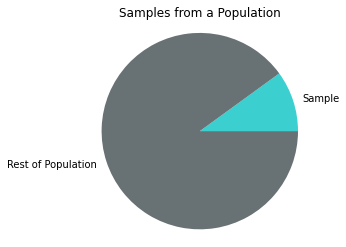

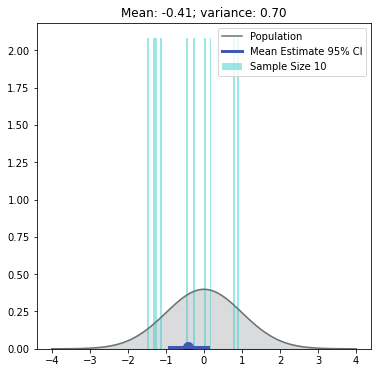

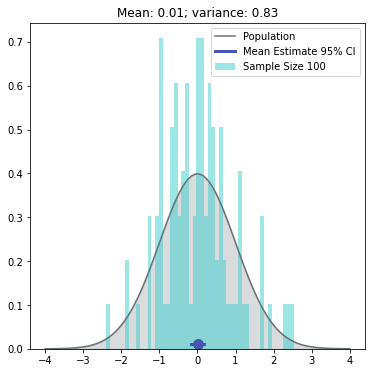

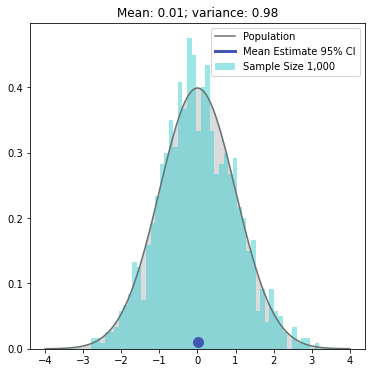

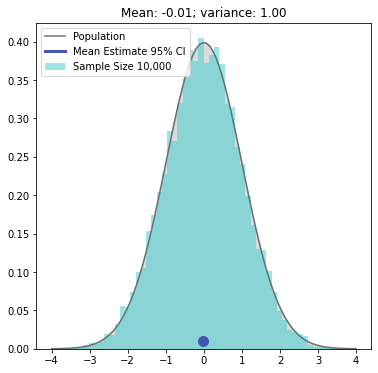

In [11]:
%pylab inline
from abra import vis
from scipy import stats

def confidence_interval(samples, confidence=.975):
    """
    Calculate the Gaussian confidence interval for the mean estimate for a set of samples
    
    Reference
    ---------
    http://www.stat.yale.edu/Courses/1997-98/101/confint.htm
    """
    z = stats.norm.ppf(confidence)
    mean = np.mean(samples)
    stderr = np.std(samples) / np.sqrt(len(samples))
    return mean, (mean - stderr * z, mean + stderr * z)


# Plot pie chart as cartoon demonstration of sampling from a population
plt.subplots(figsize=(4, 4))
plt.pie(
    [1, 9],
    colors=[vis.COLORS.cyan, vis.COLORS.gray], labels=["Sample", "Rest of Population"]
);
plt.title("Samples from a Population")
plt.axis('square')
plt.savefig('/tmp/samples.png')

def plot_sample_distribution(sample_size):
    """
    Plot samples of `sample_size`, drawn from underlying standard Gaussian distribution
    """
    population = vis.Gaussian(color=vis.COLORS.gray, label='Population')
    plt.subplots(figsize=(6, 6))
    samples = np.random.randn(sample_size)
    ci = confidence_interval(samples)
    
    plt.hist(samples, label=f'Sample Size {sample_size:,}', density=True, color=vis.COLORS.cyan, alpha=.5, bins=50)
    population.plot()
    vis.plot_interval(ci[1][0], ci[1][1], ci[0], y=.01, color=vis.COLORS.blue, label='Mean Estimate 95% CI')
    plt.axis('tight')
    plt.title('Mean: {:1.2f}; variance: {:1.2f}'.format(np.mean(samples), np.var(samples)))
    plt.legend();

# Demnstrate samples, CIs, and conversion to population for increasing sample sizes
for sample_size in [10, 100, 1000, 10000]:
    plot_sample_distribution(sample_size)
    

One type of statistical inference would be to determine whether there is a reliable relationship between independent and dependent variables associated with the population. Examples would include:
- determining the degree to which smoking (independent variable) increases the likelihood of contracting lung cancer (dependent variable)
- predicting the object labels in an image (dependent variables) based on an image's pixel values (independent variable).

Another type of statistical inference, one that will be the focus of this document, is determining if there is a real and reliable _difference between distinct groups_ in the population. For example, determining:
- Does a segment of the population that receives a drug treatment have reliably fewer negative symptoms compared to another segment that receives a placebo?
- Does formatting a website's welcome banner in Comic Sans result in a higher retention rate than the current banner formatted in Helvetica?

The last example is analogous to the standard setup of an **AB testing experiment** where a **variation** sample group of users experiences a particular version of a website (e.g. banner text formatted in Comic Sans), while a separate **control** sample group experiences the original website (e.g. banner text formatted in Helvetica).

Given this experimental setup, it is the job of the experimenter to determine if some **metric** of interest measured during the experiment (e.g. retention rate) is **significantly different between the two groups**. The magnitude and reliability of the difference is described through one or more **descriptive statistics** that are calculated on the sampled metric values and the significance of the difference is inferred by a **hypothesis test** that implements a particular **inference method** that is formulated based on those descriptive statistics (This document will address two classes of inference methods, namely Frequentist inference and Bayesian inference, and show how both can be easily implemented in ✨abracadabra✨).

### What exactly do we mean by "difference between groups"?

Before we cover hypothesis tests in more depth, let's take a step back and dig into what we actually mean by "difference between groups". What we'd like is a way to take two arrays of numbers $X_{sample}$, each associated with a sample from the populatoin, and return a single number that quantifies the "difference" (or similarity) between the two samples.

It turns out that there are quite a number of ways that samples can be compared, but a common apprach is to calculate some descriptive statistic that captures one or more properties about each of the samples' values, e.g.:
- **Central Tendencies of the sample distribution**--e.g $\text{mean}(X_a$)=$\mu_a$; median; mode
- **Spread of of the distribution**--e.g. range; standard deviation, $\text{std}(X_a$)=$\sigma_a$; variance, $\text{var}(X_a$)=$\sigma^2_a$
- **Shape of the distribution**--e.g. skewness, kurtosis

We then use a function that maps the descriptive statistics of the samples (or even the raw sample valuess) to a single, scalar that quantifies the difference/similarity between the samples. Examples include:

- **Deltas**--e.g. $\mu_b - \mu_a$
- **Ratios**--e.g. $\frac{\mu_b}{\mu_a}$
- **Divergences**--e.g. the [KL-divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) $\text{KL}(X_b || X_a)$

### Hypothesis Tests

Hypothesis tests set out to capture the multiple properties about the calculated differences that are informative for making decisions. In particular hypothesis tests attempt to capture:
- What is the **valence** of the difference? In other words, are the metrics associated with the variation group "better" or "worse" than the control's, or vice versa?
- What is the **magnitude** of the difference? In other words "how much" better or worse is one group's metric compared to the other?
- How **reliable** is the difference given in the presence of noise?

#### Quantifying comparison _valence_
For some scenarios the experimenter may simply want to determine if two samples are equal or unequal, with no consideration for the valence of the comparison. (This is the case when using a "two-tailed" Frequentist hypothesis test, but we'll get to that later). However,  for a majority of AB testing scenarious where the experimenter wants to make informed decisions to _improve_ the quality of a product, it is important to determine if the results associated with the `variation` group are "better" or "worse" than for the `control` group. This requires being able to quantify the valence of the comparison.

Quantifying valence will depend on the comparison function being used. For example, when using deltas, then the sign of the difference between the two samples can provide valence: positive sign indicates that the `variation` is "better" than the `control`, negative sign indicates "worse" results. When using ratio comparisons, it is the magnitude of the ratio, and its relation to the value one that provides valence. Ratios near one indicate little to no differnce between the two gropus, while ratios much larger than one indicate that the `variation` is performing better than the control; ratios less than one indicate poorer performance than the `control`.

#### Quantifying comparison magnitude: effect size
Not only do we care if a treatment group is "better" or "worse" than another group, but we also care about "how much" better or worse. This is where the ["effect size"](https://en.wikipedia.org/wiki/Effect_size) of comparison becomes important.

There are many definitions of effect size, each of which depends on the type of comparisons function we're employing. For example, when using deltas to compare means, one could simply take the magnitude of the difference between the means as an estimate of the effect size--i.e. $\mu_b - \mu_a$.

However, because all experiments involve sampling random variables--which are inherently noisy--it is generally a good idea to control for the degree of spread in the samples when calculating effect size. For example the Cohen's d is a commonly-used measure of effect size:

$$
\begin{align*}
d &= \frac{\mu_b - \mu_a}{\sigma_{pooled}}, \text{where} \\
\\
\sigma_{pooled} &= \sqrt{\frac{\sigma^2_a + \sigma^2_b}{2}}
\end{align*}
$$

This equation may appear somewhat complicated, but the most important thing to notice is that Cohen's d is simply the magnitude of the difference between the means, but rescaled by the amount of "spread" amongst the two groups. In this case "spread" is quantified as the pooled standard deviation $\sigma_{pooled}$. **Thus one can think of the Cohen's d effect size as a measure of "signal-to-noise" ratio:** how much of a difference can we detect between the two group means (signal),  while considering the spread of the groups (noise).

To demonstrate this idea graphically, below we plot two idealized Gaussian sample distributions while either increasing delta (signal) or increasing the variation group spread (noise). We then show how each of these manipulations effects the resulting Cohen's d effect size.


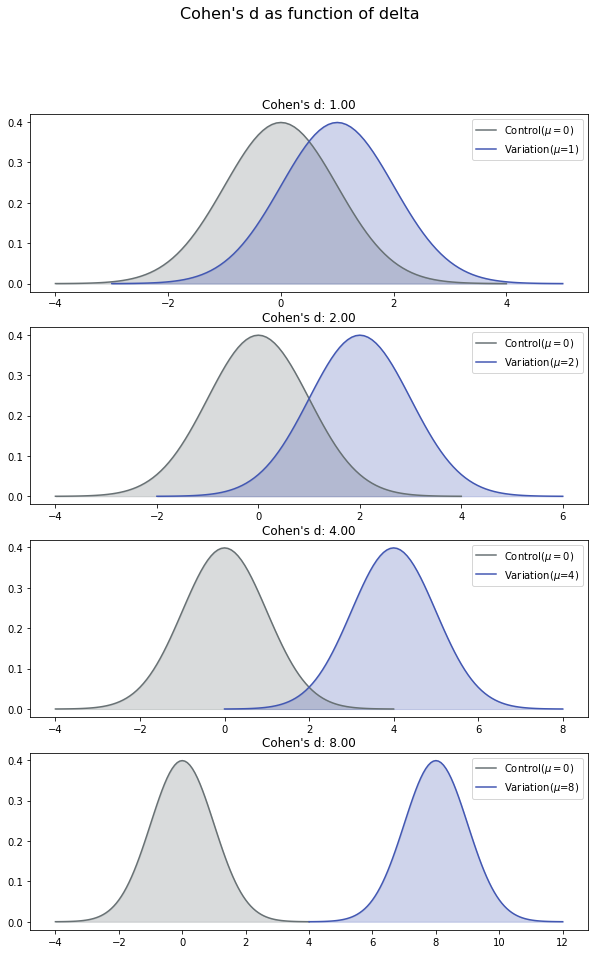

In [21]:
from abra.stats import cohens_d

def plot_cohens_d_varying_means():
    variation_means = 2**np.arange(4)
    control = vis.Gaussian(label='Control($\mu=0$)', color=vis.COLORS.gray)
    fig, axs = plt.subplots(4, figsize=(10, 15))
    for ii, vm in enumerate(variation_means):
        variation = vis.Gaussian(mean=vm, label=f'Variation($\mu$={vm})', color=vis.COLORS.blue)
        plt.sca(axs[ii])
        control.plot()
        variation.plot()
        d = cohens_d(vm, control.std, variation.std)
        plt.title(f"Cohen's d: {d:1.2f}")
        plt.legend()
    plt.suptitle("Cohen's d as function of delta", fontsize=16)
        
def plot_cohens_d_varying_std():
    variation_std = 2**np.arange(4)
    variation_mean = 3
    control = vis.Gaussian(label='Control(std=1)', color=vis.COLORS.gray)
    fig, axs = plt.subplots(4, figsize=(10, 15))
    for ii, vs in enumerate(variation_std):
        variation = vis.Gaussian(mean=variation_mean, std=vs, label=f'Variation(std={vs})', color=vis.COLORS.blue)
        plt.sca(axs[ii])
        control.plot()
        variation.plot()
        d = cohens_d(vs, control.std, variation.std)
        plt.title(f"Cohen's d: {d:1.2f}")
        plt.legend()
    plt.suptitle("Cohen's d as function of std", fontsize=16)
        
plot_cohens_d_varying_means()

We see that increasing the magnitude of $\mu_{variation} - \mu_{control}$ while keeping the std constant increases the calculated value of Cohen's d. Now let's see what happens if we hold the means fixed but increase the standard deviation of the variation group (control group held constant).

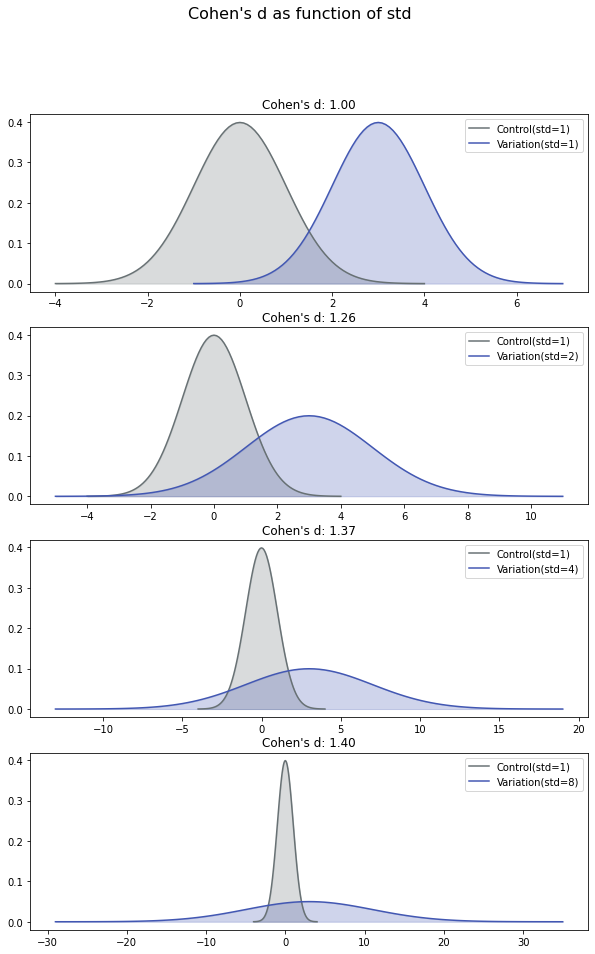

In [22]:
plot_cohens_d_varying_std()

We can see that increasing the pooled standard deviation while keeping the value of $\mu_{variation} - \mu_{control}$ constant decreases the effect size.

As we'll see shortly, understanding how effect size is related to BOTH the difference between groups AND the spread of each group is important when planning and interpreting the results of experiments.

#### Quantifying the reliability of differences
Samples are never perfect and there is always noise in the system. How confident can we be about the decisions made based on the output of hypothesis tests.

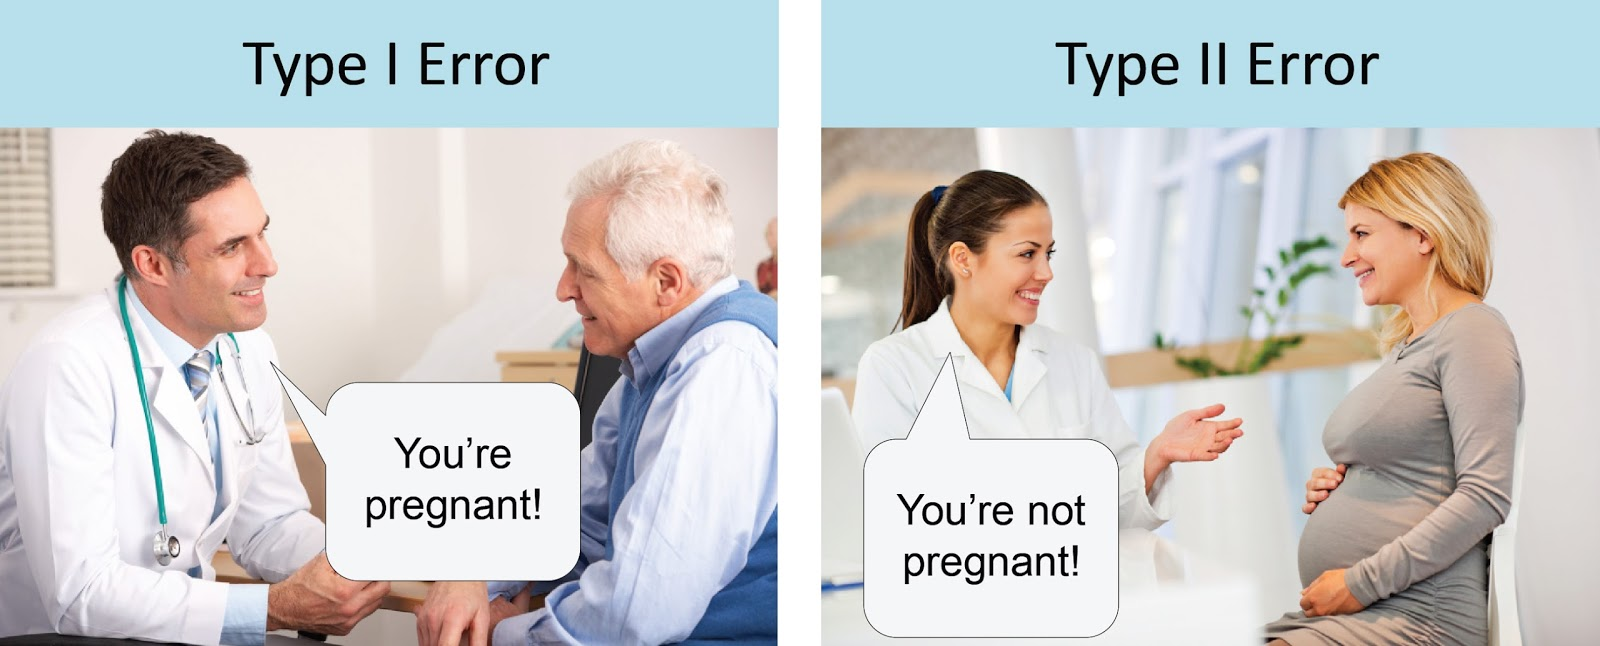

In [15]:
typeiandtypeiierror_url = "https://shuzhanfan.github.io/assets/images/typeiandtypeiierror.jpg"
from IPython.display import Image
Image(
    url=typeiandtypeiierror_url,
    retina=True, embed=True,
    metadata={"source": typeiandtypeiierror_url}
)


#### Quantifying magnitude and effect size
Not only do we care if a treatment group is "better" or "worse" than another group, but we also care about "how much" better or worse one group is compared to another. This is where the ["effect size"](https://en.wikipedia.org/wiki/Effect_size) of comparison becomes important.

There are many definitions of effect size each of which depends on the type of comparisons we're employing. For example, when using deltas, the Cohen's d measure is commonly used:

$$
\begin{align*}
d &= \frac{\mu_b - \mu_a}{\sigma_{pooled}}, \text{where often} \\
\\
\sigma_{pooled} &= \sqrt{\frac{\sigma^2_a + \sigma^2_b}{2}}
\end{align*}
$$


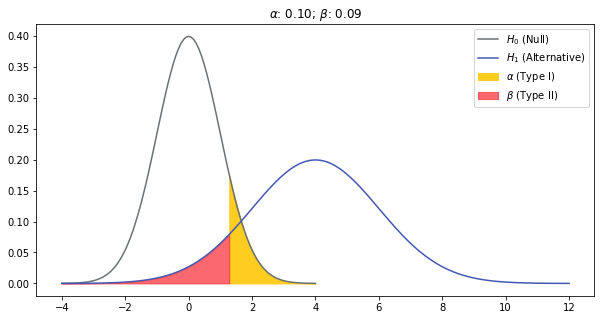

In [59]:
def plot_alpha_beta(alpha=.01, null_mean=0, null_std=1, alt_mean=4, alt_std=2, plot_power=False):
    """Visualize the relationship between Type I and Type II error (assuming right-tailed test),
    assuming Gaussian Null and Alternative hypothesis parameterizations.
    """
    null = vis.Gaussian(mean=null_mean, std=null_std, label='$H_0$ (Null)', color=vis.COLORS.gray, fill=False)
    alternative = vis.Gaussian(mean=alt_mean, std=alt_std, label='$H_1$ (Alternative)', color=vis.COLORS.blue, fill=False)

    x_at_alpha = null.ppf(1-alpha)  # one-tailed
    x_alpha = np.linspace(x_at_alpha, null.xgrid().max())
    
    beta = alternative.cdf(x_at_alpha)
    x_beta = np.linspace(alternative.xgrid().min(), x_at_alpha)
    
    plt.subplots(figsize=(10, 5)) 
    
    # Plot distributions
    null.plot()
    alternative.plot()
    
    # Plot errors
    null.plot_area(x_alpha, alpha=1, color=vis.COLORS.yellow, label=r'$\alpha$ (Type I)')
    alternative.plot_area(x_beta, alpha=.75, color=vis.COLORS.red, label=r'$\beta$ (Type II)')
    
    # Plot power
    if plot_power:
        power = 1 - beta
        x_power = np.linspace(x_at_alpha, alternative.xgrid().max())
        alternative.plot_area(x_power, alpha=.5, color=vis.COLORS.cyan, label=r'Power (1-$\beta$)')
        plt.title(r"$\alpha$: {:1.2f}; $\beta$: {:1.2f}; Power: {:1.2f}".format(alpha, beta, power))
    else:
        plt.title(r"$\alpha$: {:1.2f}; $\beta$: {:1.2f}".format(alpha, beta))
    plt.legend()

plot_alpha_beta(.1)

## Inferential Statistics
- Effect Size
- Type I rate
- Power

$$
\begin{align*}
z &= \frac{\mu_a - \mu_b}{\sigma^2_{pooled}}, \text{where} \\
\\
\text{SE}_{pooled} &= \sqrt{\frac{\sigma^2_a}{n_a} + \frac{\sigma^2_b}{n_b}}
\end{align*}
$$

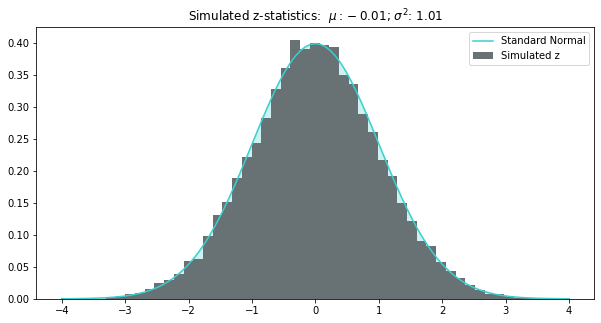

In [17]:
def simulate_z(n_simulations=20000, n_observations=100):
    z_statistics = []
    for _ in range(n_simulations):
        
        # no difference in random variables
        samples_a = np.random.randn(n_observations)
        samples_b = np.random.randn(n_observations)
        
        mean_a = np.mean(samples_a)
        mean_b = np.mean(samples_b)
        
        variance_a = np.var(samples_a)
        variance_b = np.var(samples_b)
        
        pooled_std_error = np.sqrt(variance_a / n_observations + variance_b / n_observations)
        
        z_statistic = (mean_a - mean_b) / pooled_std_error
        z_statistics.append(z_statistic)
        
    return z_statistics

simulated_z = simulate_z()
plt.subplots(figsize=(10, 5))
plt.hist(simulated_z, density=True, bins=50, color=vis.COLORS.gray, label='Simulated z')
standard_normal = vis.Gaussian(mean=0, std=1, color=vis.COLORS.cyan, label='Standard Normal')
standard_normal.plot()
plt.title(r'Simulated z-statistics:  $\mu: {:1.2f}$; $\sigma^2$: {:1.2f}'.format(np.mean(simulated_z), np.var(simulated_z)))
plt.legend();

### Type I Error, Type II Error, and Inferential Power

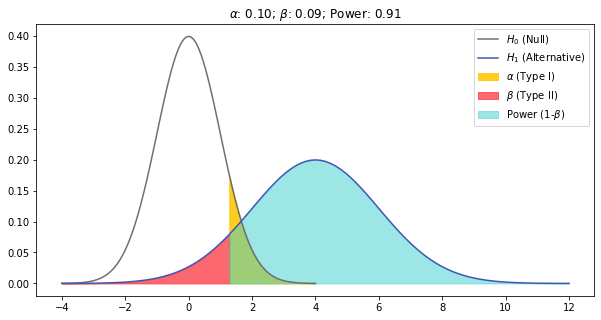

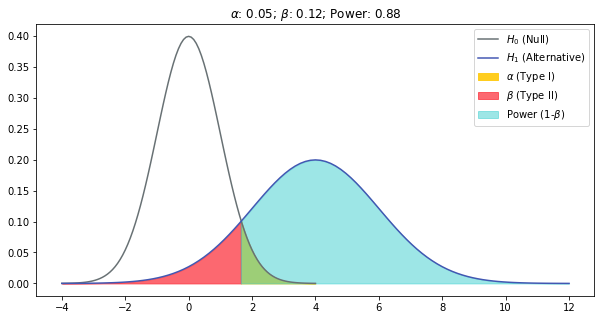

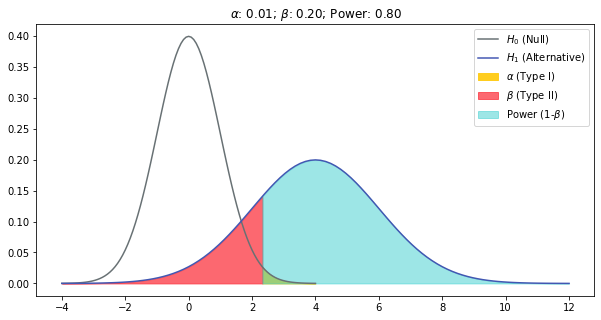

In [58]:
for alpha in [.1, .05, .01]:
    plot_alpha_beta(alpha=alpha, plot_power=True)

## Frequentist Approach to Inference

## Bayeisan Approach to Inference

## Performing Experiment Analysis with ✨abracadabra✨
### Planning Experiments
- Statistical considerations when planning
  - what metrics are being measured?
    - what is their support?
      - is it a count, conversion, or continuous variable
    - this will affect the analysis required
  - what is the current base rate of the metric?
  - how much of a change would be deemed a "success"
    - use sizing --> if you reached lift goal, how much will it affect bottom line
    - this is how you define your desired "effect size"
  - Use effect size to define the required sample size
    - What’s desired Type I rate?
    - What’s desired power?
      - Requires an estimate of the control and variation spread
    - Are we running multiple treatments simultaneously? What MC do we want?
    - What type of variable is this?
       - Count? Proportion? Continuous?
       - This will affect your calculations
    - Can use Abracadabra to consistently get all of these 
       - `estimate_experiment_sample_sizes`

    
  - will make experiment more efficient
  - for large-scale experiemnts, this reduces ingestion bandwidth and storage
  - know when to end experiments early if needed